In [1]:
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

import tensorflow as tf
import yolo.config as cfg

Using TensorFlow backend.


In [2]:
keras.backend.set_image_dim_ordering('th')
weights_path = 'yolo-tiny.weights'
is_freeze = True

In [3]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1), 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same', 
                        activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Convolution2D(1024,3,3 ,border_mode='same', activation=LeakyReLU(alpha=0.1), trainable=not is_freeze))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [4]:
def say(*words, verbalise=False):
    if verbalise:
        print(list(words))

def convert_darkweights2keras(model, weigths_path, verbalise=False):
    data = np.fromfile(weights_path, np.float32)
    data = data[4:]
    say("weights shape : ", data.shape, verbalise=verbalise)
    idx = 0
    for i,layer in enumerate(model.layers):
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape,bshape = shape
            bia = data[idx:idx+np.prod(bshape)].reshape(bshape)
            idx += np.prod(bshape)
            ker = data[idx:idx+np.prod(kshape)].reshape(kshape)
            idx += np.prod(kshape)
            layer.set_weights([ker,bia])
    say("convert np weights file -> kears models", "Successful", verbalise=verbalise)

In [5]:
#sess = K.get_session()
#sess.run(tf.global_variables_initializer())

convert_darkweights2keras(model, weights_path, verbalise=True)

['weights shape : ', (45089374,)]
['convert np weights file -> kears models', 'Successful']


In [6]:
save_weights_path = 'yolo-tiny-origin.h5'
save_result = model.save_weights(save_weights_path)
save_result

In [7]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 112, 112)  0           convolution2d_2[0][0]            
___________________________________________________________________________________________

## Test Forward Path

base :  3
('aeroplane', (254.0, 254.0, 254))
('bicycle', (239.88888888888889, 211.66666666666669, 127))
('bird', (225.77777777777777, 169.33333333333334, 0))
('boat', (211.66666666666669, 127.0, 254))
('bottle', (197.55555555555557, 84.66666666666667, 127))
('bus', (183.44444444444443, 42.33333333333332, 0))
('car', (169.33333333333334, 0.0, 254))
('cat', (155.22222222222223, -42.33333333333335, 127))
('chair', (141.11111111111111, -84.66666666666664, 0))
('cow', (127.0, 254.0, 254))
('diningtable', (112.88888888888889, 211.66666666666669, 127))
('dog', (98.77777777777777, 169.33333333333334, 0))
('horse', (84.66666666666667, 127.0, 254))
('motorbike', (70.55555555555556, 84.66666666666667, 127))
('person', (56.44444444444444, 42.33333333333332, 0))
('pottedplant', (42.33333333333332, 0.0, 254))
('sheep', (28.222222222222236, -42.33333333333335, 127))
('sofa', (14.111111111111118, -84.66666666666664, 0))
('train', (0.0, 254.0, 254))
('tvmonitor', (-14.111111111111118, 211.6666666666666

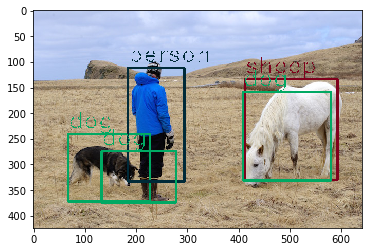

In [7]:
from utils.BoxUtils import post_progress

imagePath = './test/my_testset/person.jpg'
image = cv2.imread(imagePath)
print("1", image.shape)
resized = cv2.resize(image,(448,448))
plt.imshow(resized)
print("2", resized.shape)
np_img = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
batch = np.transpose(np_img,(2,0,1))
print("3", batch.shape)
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
print("4", batch.shape)
out = model.predict(batch)
print("5", out.shape)

out_img = post_progress(out[0], im=image, is_save=False, threshold=0.1)
print("6", out_img.shape)
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
plt.imshow(out_img)


max_index: 16, left: 412, top: 134, right: 592, bottom: 330
max_index: 11, left: 68, top: 241, right: 227, bottom: 372
max_index: 14, left: 184, top: 112, right: 294, bottom: 333
max_index: 11, left: 133, top: 274, right: 278, bottom: 374
max_index: 11, left: 408, top: 159, right: 579, bottom: 331
(424, 640, 3)


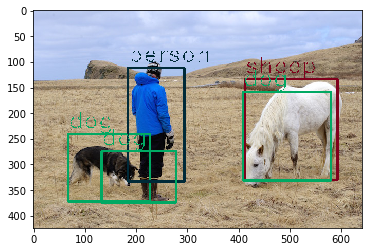

In [8]:
inp_x = tf.placeholder(tf.float32, shape=(None, 3, 448, 448))
net_out = model(inp_x)
sess = K.get_session()
out2 = sess.run(net_out, feed_dict={inp_x:batch})
out_img2 = post_progress(out2[0], im=image, is_save=False, threshold=0.1)
print(out_img2.shape)
out_img2 = cv2.cvtColor(out_img2, cv2.COLOR_BGR2RGB)
plt.imshow(out_img2)

In [9]:
from yolo.training_v1 import darkeras_loss, _TRAINER
from yolo.dataset.data import shuffle

In [10]:
inp_x = tf.placeholder(tf.float32, shape=(None, 3, 448, 448))
net_out = model(inp_x)
sess = K.get_session()

say("Building {} loss function".format(cfg.model_name))
loss_ph, loss_op = darkeras_loss(net_out)
say("Building {} train optimizer".format(cfg.model_name))
optimizer = _TRAINER[cfg.trainer](cfg.lr)
gradients = optimizer.compute_gradients(loss_op)
train_op = optimizer.apply_gradients(gradients)

sess.run(tf.global_variables_initializer())

convert_darkweights2keras(model, weights_path, verbalise=True)

batches = shuffle()
for i, (x_batch, datum) in enumerate(batches):
    train_feed_dict = {
       loss_ph[key]:datum[key] for key in loss_ph 
    }
    train_feed_dict[inp_x] = x_batch
    # print("feed_dict.keys() : ", len(train_feed_dict.keys()), train_feed_dict.keys())
    fetches = [train_op, loss_op] 
    fetched = sess.run(fetches, feed_dict=train_feed_dict)
    
    loss_val = fetched[1]
    say("step {} - loss {}".format(i, loss_val), verbalise=True)
    if i == 1:
        save_step_weigths_path = 'yolo-tiny-step{}.h5'.format(i)
        model.save_weights(save_step_weigths_path)
        print("Saved weigths : ", save_step_weigths_path)

Building yolo-tiny loss
['weights shape : ', (45089374,)]
['convert np weights file -> kears models', 'Successful']
Dataset of 9963 instance(s)
shuffle index :  [4624 2992 3478 ..., 3245 9404 6919]
['step 0 - loss 2.3316383361816406']
['step 1 - loss 2.4186501502990723']
Saved weigths :  yolo-tiny-step1.h5
['step 2 - loss 1.883292555809021']
['step 3 - loss 2.1444711685180664']
['step 4 - loss 2.8744101524353027']


KeyboardInterrupt: 

## Lets Train this!

In [7]:
import tensorflow as tf

In [8]:
from yolo.training_v1 import darkeras_loss, __

In [9]:
model.compile(loss=darkeras_loss,
             optimizer=keras.optimizers.adam(),
             metrics=None)

ValueError: Shape must be at least rank 2 but is rank 1 for 'concat_1' (op: 'ConcatV2') with input shapes: [?], [?], [?], [].